In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Supervised Learning - Project

In this Project, we are going to perform a full supervised learning machine learning project on a "Diabetes" dataset. This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. 

[Kaggle Dataset](https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset)

In [2]:
df=pd.read_csv('diabetes.csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Part I : EDA - Exploratory Data Analysis

For this task, you are required to conduct an exploratory data analysis on the diabetes dataset. You have the freedom to choose the visualizations you want to use, but your analysis should cover the following tasks mostly:

- Are there any missing values in the dataset? -
- How are the predictor variables related to the outcome variable? - 
- What is the correlation between the predictor variables? - 
- What is the distribution of each predictor variable? -
- Are there any outliers in the predictor variables?
- How are the predictor variables related to each other? -
- Is there any interaction effect between the predictor variables? -
- What is the average age of the individuals in the dataset? -
- What is the average glucose level for individuals with diabetes and without diabetes? -
- What is the average BMI for individuals with diabetes and without diabetes? -
- How does the distribution of the predictor variables differ for individuals with diabetes and without diabetes? -
- Are there any differences in the predictor variables between males and females (if gender information is available)? - not available

### 1. Missing Values
- There are none in this dataset - at least not in the form of NaN or None

In [4]:
missing_values = df.isnull().sum()
print(missing_values)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### 2. How Are Predictor Variables Related to the Outcome Variable (with Averages and SD by outcomes)

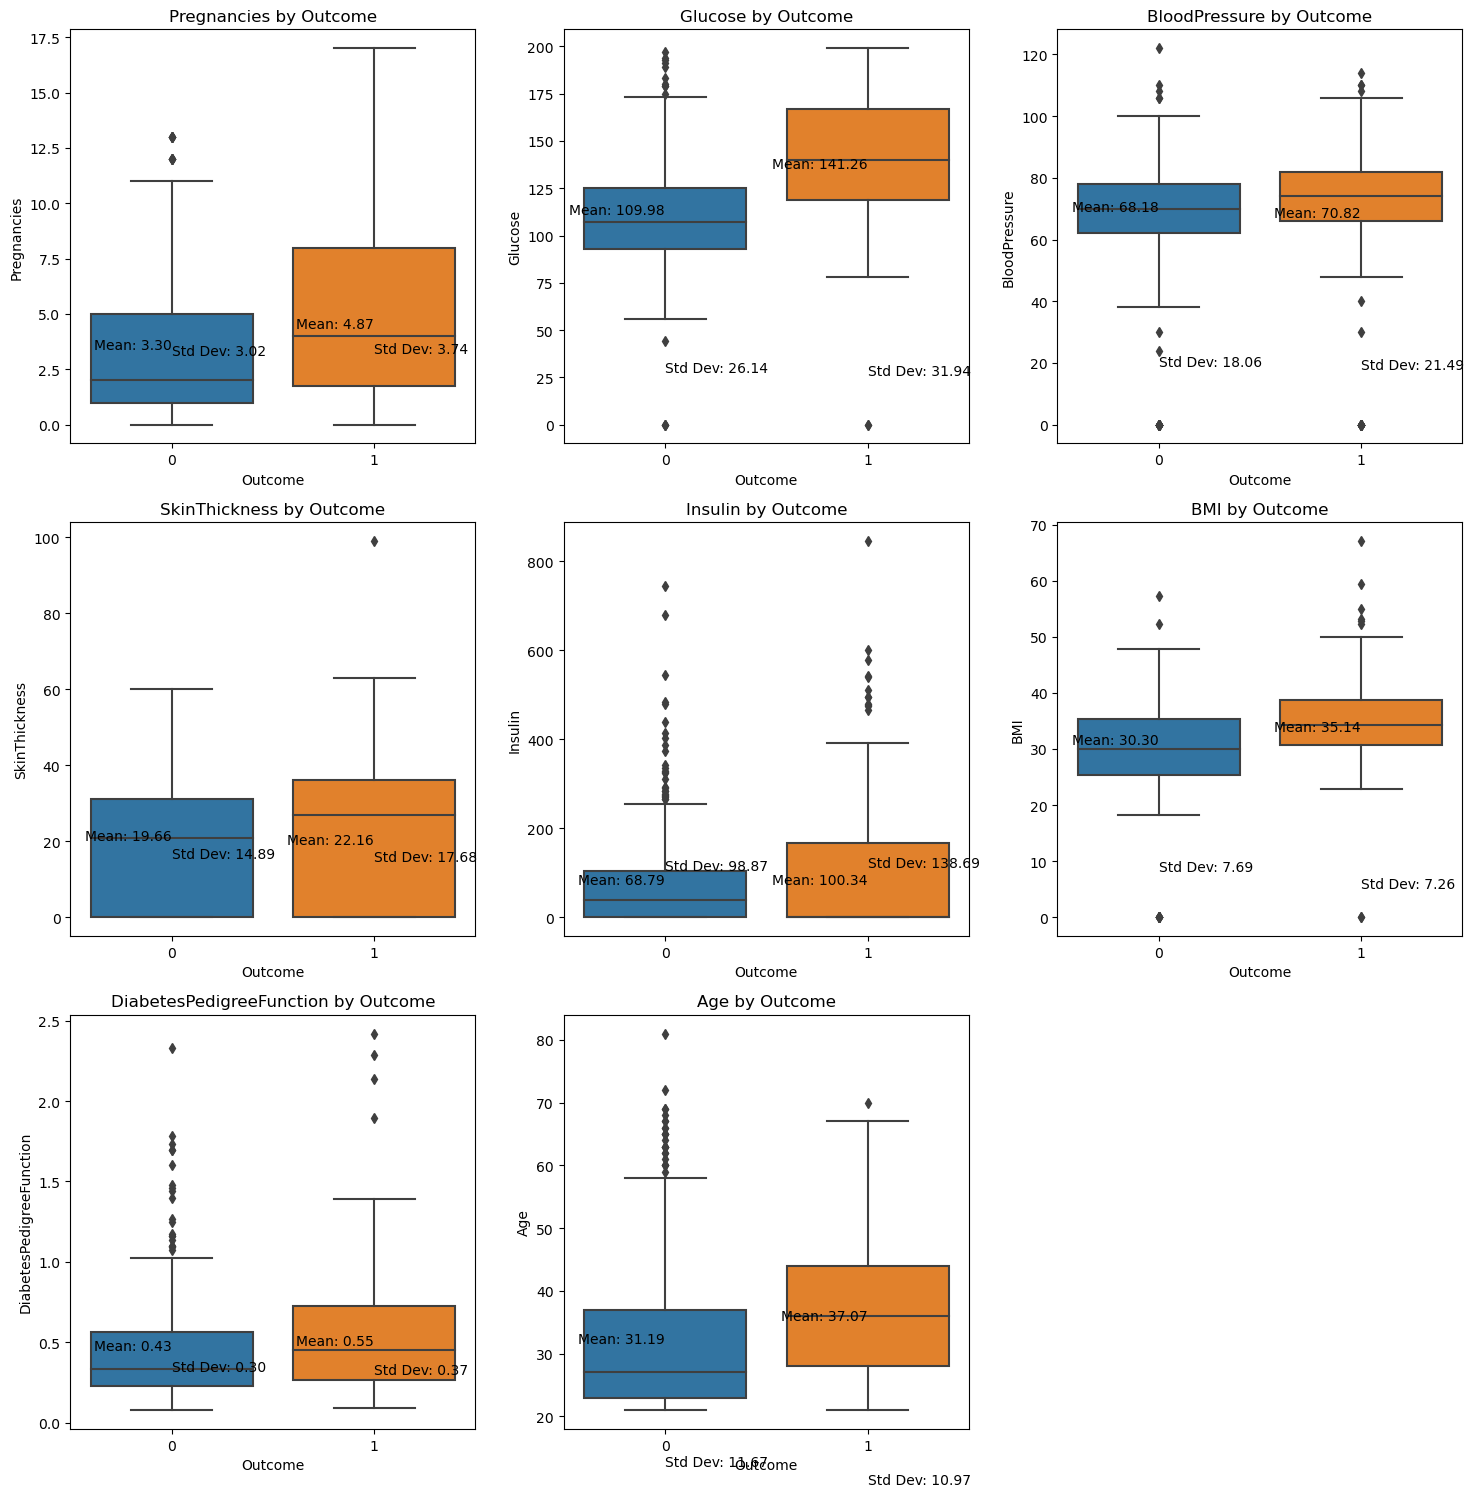

In [5]:
# Suppressing the Future Warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Creating a grid for the box plots of predictors
predictor_variables = df.columns[:-1]
n_cols = 3
n_rows = (len(predictor_variables) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 15))

for i, column in enumerate(predictor_variables, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if isinstance(df[column].dtype, pd.CategoricalDtype):
        sns.boxplot(x='Outcome', y=column, data=df, sym="")
    else:
        sns.boxplot(x='Outcome', y=column, data=df)
    
    plt.title(f'{column} by Outcome')
    
    # Calculate and display the means and standard deviations as labels in readable positions
    mean_0 = df[df['Outcome'] == 0][column].mean()
    mean_1 = df[df['Outcome'] == 1][column].mean()
    std_0 = df[df['Outcome'] == 0][column].std()
    std_1 = df[df['Outcome'] == 1][column].std()
    
    ax = plt.gca()
    ax.text(0, mean_0, f'Mean: {mean_0:.2f}', ha='right', va='bottom')
    ax.text(1, mean_1, f'Mean: {mean_1:.2f}', ha='right', va='top')
    ax.text(0, std_0, f'Std Dev: {std_0:.2f}', ha='left', va='bottom')
    ax.text(1, std_1, f'Std Dev: {std_1:.2f}', ha='left', va='top')

plt.tight_layout()
plt.show()

#### Observations:
- We can see that there are some fairly distinct differences in distributions between predictors and the outcomes.  Particularly for pregnancy, glucose, BMI, and age.
- The average age of the individuals in the dataset is ~31 for those without diabetes and ~37 for those with diabetes.
- The average glucose level for those without diabetes is ~110 and those with diabetes is ~141
- The average BMI for individuals without diabetes is ~30 and for those with diabetes is ~35

### 3. What is the correlation between the predictor variables? Correlation between predictors and target?

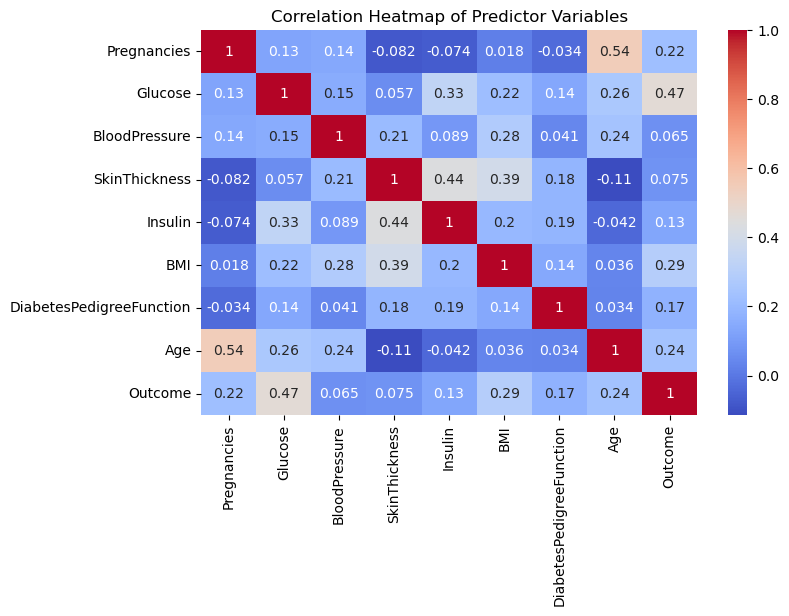

In [6]:
# Calculate the correlation matrix for all variables
correlation_matrix = df.corr()

# Generating a heatmat of the correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Predictor Variables")
plt.show()

#### Observations
- The correlation between Outcome and Glucose is high. Glucose seems to be the most important feature in model training.
- BMI, Pregnancies and Age also appear to be fairly important features for training our model.
- There appears to be some relatively high correlations between SkinThickness, BMI, Insulin, and Blood Pressure. There may be a multicollinearity problem here, but we can investigate this again later after dealing with missing values and outliers.
- We do also see the highest correlation we see are between age and pregnancies.  This is not a surprise since there are typically more pregnancies as a woman ages.

### 4. Distributions of Predictors - Detecting Missing Values and Outliers

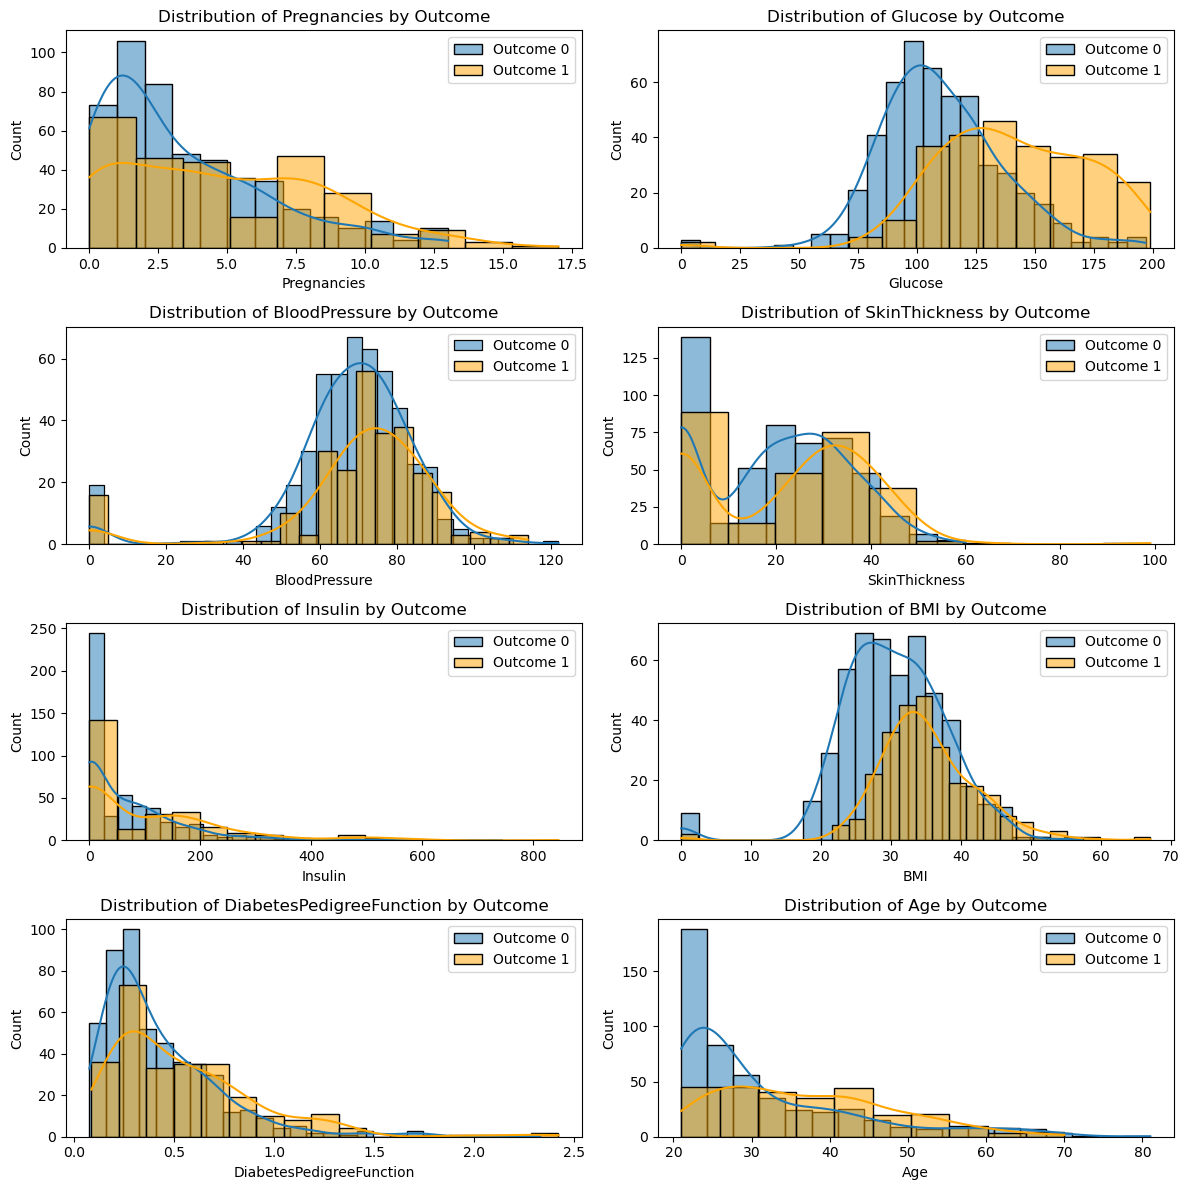

In [7]:
# Working out the number of rows for the distributions if I want 2 columns
n_rows = len(predictor_variables) // 2 + len(predictor_variables) % 2  

# Creating my figure for the distribution grid
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 3 * n_rows))

# Cycling through all predictors and creating an overlapping histogram for both outcomes
for i, column in enumerate(predictor_variables):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Create histograms for 0 and 1 outcomes
    sns.histplot(df[df['Outcome'] == 0][column], kde=True, label='Outcome 0', ax=ax)
    sns.histplot(df[df['Outcome'] == 1][column], kde=True, label='Outcome 1', color='orange', ax=ax)

    ax.set_title(f'Distribution of {column} by Outcome')
    ax.set_xlabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

#### Observations
- Some of these distributions explain why we might have seen larger corellations between some of the predictors - because they have a number of 0-values in them.
- We see that there are 0-values input for BMI, Insulin, Skin Thickness, Blood Pressure, and Glucose.  Values of zero are improbable or impossible in some cases, and we can assume this is data that just wasn't filled in correctly or left blank.
- We need to address these outliers and missing values appropriately - more on this in Part II
- There are a number of 0-values for pregnancies, but this is a probable number since it's possible many women included in this dataset have not been pregnant.

#### I want to count the number of entries that are zero for each of these concerning predictors, then see how many entries we have in total, along with how many entries have 3 or more of these specific predictors with zeros in them.  This will help to inform me of what to do with the zero values or the rows that have too many zeros.

In [8]:
# List of predictor variables with zeros that we are interested in exploring
predictor_variables_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Dictionary for zero counts
zero_counts = {}

# Counting number of zero entries for each of these predictors, updating the dictionary along the way
for variable in predictor_variables_with_zeros:
    zero_counts[variable] = len(df[df[variable] == 0])

# Display the counts
for variable, count in zero_counts.items():
    print(f'Number of rows with zero {variable}: {count}')

Number of rows with zero Glucose: 5
Number of rows with zero BloodPressure: 35
Number of rows with zero SkinThickness: 227
Number of rows with zero Insulin: 374
Number of rows with zero BMI: 11


In [9]:
# Count the number of zeros for each predictor variable
df['Zeros_Count'] = df[predictor_variables_with_zeros].apply(lambda row: row.eq(0).sum(), axis=1)

# Count the number of rows/entries that have 3 or more zeros in them
count_entries_with_zeros = len(df[df['Zeros_Count'] >= 3])

# Display the counts
print(f'Number of entries with 3 or more zeros in the specified predictors: {count_entries_with_zeros}')

Number of entries with 3 or more zeros in the specified predictors: 35


In [10]:
df.shape

(768, 10)

In [11]:
# Check how many rows have zero values for both Skin Thickness and Insulin
zero_skin_and_insulin = df[(df['SkinThickness'] == 0) & (df['Insulin'] == 0)]

# Count the number of such rows
count = len(zero_skin_and_insulin)

# Display the count
print(f'Number of rows with zero Skin Thickness and zero Insulin: {count}')

Number of rows with zero Skin Thickness and zero Insulin: 227


#### Observations
- We can see that there are 35 rows that have 3 or more zero-entries for these specific predictors.  We can also see that the dataset only contains 768 rows.  To eliminate these rows with too much missing data would be eliminating almost 5% of the entire dataset, which is quite a bit of loss.  However, with that many missing values in a single entry, it's difficult to use the other predictors within the same entry to inform us of how to replace them.  Therefore, these 35 columns I will eliminate from the dataset.
- As far as the remaining zero entries for Glucose, Blood Pressure, and BMI, there are so few of them that I'm comfortable with simply replacing these with the mean or median values. (Alterations in Part II)
- There are ALOT of zeros found in the Skin Thickness and Insulin columns and we need to be careful with these.  For these two I'm going to use their strongest correlations with two other predictors in order to predict the values.
- It appears that all of the zero-values for skin-thickness also have zero-values listed for insulin, so I will not be using this relationship to predict the values for skin-thickness and vice-versa.
##### Conclusions of what to do with zero-values for Skin Thickness and Insulin:
- For Skin-Thickness, since I will cannot use insulin as an aide in replacing zero-values, I'll use the next two best correlations from above - Blood Pressure and BMI.
- For Insulin, I will use the best two correlations to replace the non-zero values. That is, Glucose and BMI.

#### **Aside**: After making these proposed changes (in Part II), we have no more zero-values and more normally distributed values for our predictors.  We do, however, still have some outliers to deal with

### Outliers
##### Let's re-do the box and whisker plots to detect our outliers

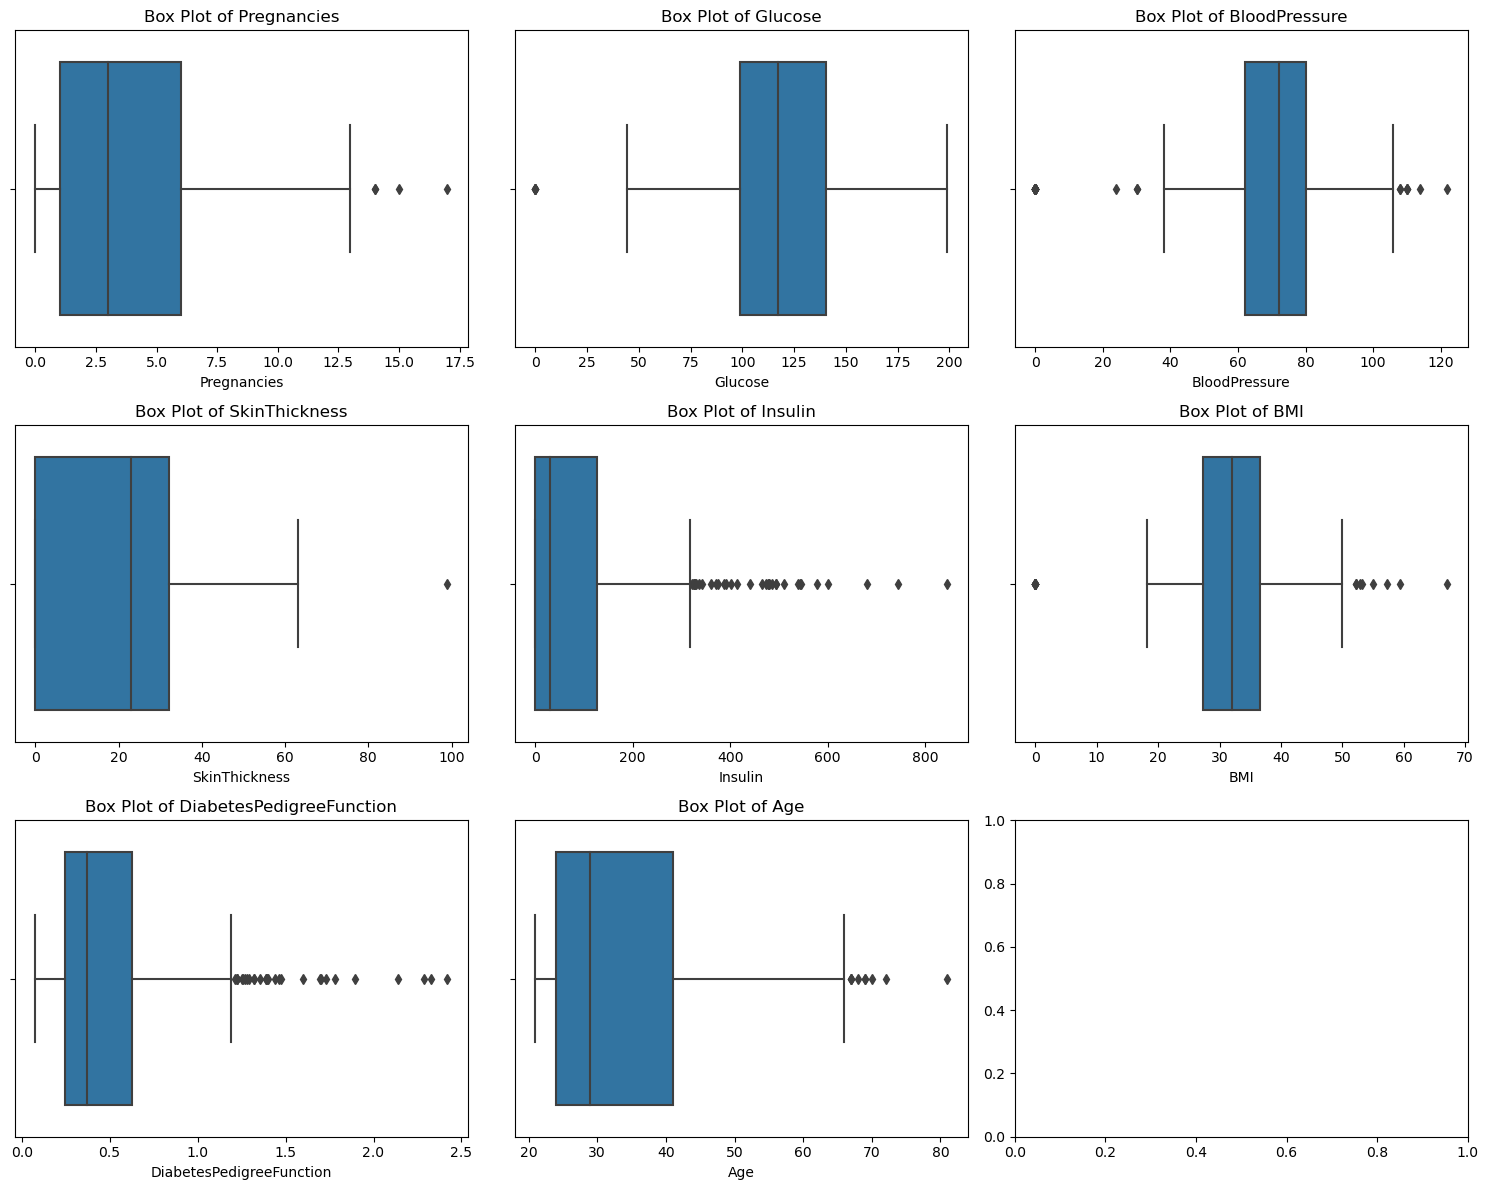

In [12]:
# Define the number of columns and rows for the grid
n_cols = 3
n_rows = (len(predictor_variables) + n_cols - 1) // n_cols

# Set up the figure and axes in a grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))

for i, column in enumerate(predictor_variables):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Create a box plot to visualize the distribution and identify outliers
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel(column)


plt.tight_layout()
plt.show()

#### Observations
Interpretation of Outliers.
- In pregnancies the plot is showing outliers for 13,15 and 17 pregnancies but I will not remove these, since it's possible for women to bear 17 children.
- Glucose contains outliers at 0, but these will be dealt with the other "Missing Values"
- Blood pressure has outliers at 0 (dealt with later) and some between 20 and 40, which I will remove.  I will leave the higher blood pressures since these are not pressures out of the range of possibility 
- The outliers in skin thickness are very far from the upper quartile so I will remove these.
- Since many of the insulin values were found to be zero, this box and whisker plot is likely quite misleading.  I will handle the zero-values, and deal with the remaining outliers using appropriate scaling and normalization.
- For BMI, I'll look a little further into the number of values that are above 50. Although these values are theoretically possible, they are highly unlikely.
- Diabetes pedigree function scores can vary based on family history, so these will be left alone.
- The boxplot of age also has some outliers, but since people with ages up to 100+ can exist, I will not remove them.
- Any outliers not explicitly eliminated will be mitigated to some degree in the Scaling Process

# Part II : Preprocessing & Feature Engineering

You need to perform preprocessing on the given dataset. Please consider the following tasks and carry out the necessary steps accordingly.
- Handling missing values
- Handling outliers
- Scaling and normalization
- Feature Engineering
- Handling imbalanced data

### 1. Handling Missing Values
##### As per the Suggested changes mentioned in Part I:
- Eliminate all entries that have 3 or more zero-values listed in either 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', or 'BMI'.  There were 35 of these in total (accounts for nearly 5% of the dataset).
- Replace zero-values for Glucose, Blood Pressure, and BMI with the means since there are not many of these in comparison to the entire dataset.
- Replace zero-values for Insulin with the average Insulin of entries with "similar" BMI and Glucose values.
- Replace zero-values for Skin Thickess with the average Skin Thickness of entries with "similar" BMI and Blood Pressure values.

In [13]:
# Remove rows with 3 or more zeros in either 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', or 'BMI'.  Here we use the column
# 'Zeros_Count' created in Part I
df = df[df['Zeros_Count'] < 3]

# Drop the 'Zeros_Count' column as it's no longer needed
df = df.drop(columns=['Zeros_Count'])

In [14]:
df.shape

(733, 9)

In [15]:
# Calculate the means of the respective predictor variables
mean_values = df[['Glucose', 'BloodPressure', 'BMI']].mean()

# Replace zero-values with means
for variable in ['Glucose', 'BloodPressure', 'BMI']:
    df.loc[df[variable] == 0, variable] = mean_values[variable]

In [16]:
# Define a threshold for similarity in BMI and Glucose values this will inform my acceptable range of values to consider in the average
similarity_threshold = 0.20  # I will use a 20% range of values

# Identify entries with zero values for Insulin
zero_insulin = df[df['Insulin'] == 0]

# Calculate the overall average Insulin
overall_average_insulin = df['Insulin'].mean()

# Loop through entries with zero Insulin and replace with average of similar entries
for index, row in zero_insulin.iterrows():
    similar_entries = df[
        (df['BMI'] >= row['BMI'] - similarity_threshold*row['BMI']) &
        (df['BMI'] <= row['BMI'] + similarity_threshold*row['BMI']) &
        (df['Glucose'] >= row['Glucose'] - similarity_threshold*row['Glucose']) &
        (df['Glucose'] <= row['Glucose'] + similarity_threshold*row['Glucose'])
    ]
    
    if not similar_entries.empty:
        average_insulin = similar_entries['Insulin'].mean()
        df.at[index, 'Insulin'] = average_insulin
        
    else:
        df.at[index, 'Insulin'] = overall_average_insulin

In [17]:
# Define a threshold for similarity in BMI and Blood Pressure values
similarity_threshold = 0.20  # Use a 20% range of values

# Identify entries with zero values for Skin Thickness
zero_skin_thickness = df[df['SkinThickness'] == 0]

# Calculate the overall average Skin Thickness
overall_average_skin_thickness = df['SkinThickness'].mean()

# Loop through entries with zero Skin Thickness and replace with average of similar entries
for index, row in zero_skin_thickness.iterrows():
    similar_entries = df[
        (df['BMI'] >= row['BMI'] - similarity_threshold * row['BMI']) &
        (df['BMI'] <= row['BMI'] + similarity_threshold * row['BMI']) &
        (df['BloodPressure'] >= row['BloodPressure'] - similarity_threshold * row['BloodPressure']) &
        (df['BloodPressure'] <= row['BloodPressure'] + similarity_threshold * row['BloodPressure'])
    ]

    if not similar_entries.empty:
        average_skin_thickness = similar_entries['SkinThickness'].mean()
        df.at[index, 'SkinThickness'] = average_skin_thickness

    else:
        df.at[index, 'SkinThickness'] = overall_average_skin_thickness

In [18]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,3.858117,121.806145,72.359242,27.508840,128.284809,32.474998,0.476502,33.287858,0.343793
std,3.372025,30.597882,12.346238,9.873188,96.604252,6.873017,0.334200,11.749216,0.475297
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,20.000000,70.936742,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,27.000000,101.051848,32.386630,0.380000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,33.000000,155.000000,36.600000,0.629000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Let's get a recount of the zero-values

In [19]:
# List of predictor variables with zeros that we are interested in exploring
predictor_variables_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Dictionary for zero counts
zero_counts = {}

# Counting number of zero entries for each of these predictors, updating the dictionary
for variable in predictor_variables_with_zeros:
    zero_counts[variable] = len(df[df[variable] == 0])

# Display the counts
for variable, count in zero_counts.items():
    print(f'Number of rows with zero {variable}: {count}')

Number of rows with zero Glucose: 0
Number of rows with zero BloodPressure: 0
Number of rows with zero SkinThickness: 1
Number of rows with zero Insulin: 1
Number of rows with zero BMI: 0


- We still seem to have two zero-values. I can live with that

### 2. Handling Outliers
#### As per the suggestions in Part I
- Remove lower outliers for Blood Pressures. Higher outliers left alone.
- Remove upper outliers in skin thickness.
- Remove upper outliers for BMI, depending one how many there are.

In [20]:
# Removing lower outliers in BP
lower_quart_bp = df['BloodPressure'].quantile(0.25)
iqr_bp = 1.5 * (df['BloodPressure'].quantile(0.75) - lower_quart_bp)
df = df[df['BloodPressure'] >= (lower_quart_bp - iqr_bp)]

# Removing upper outliers in Skin Thickness
df = df[df['SkinThickness'] <= 80]

# Removing upper outliers in BMI
upper_quart_bmi = df['BMI'].quantile(0.75)
iqr_bmi = 1.5 * (upper_quart_bmi - df['BMI'].quantile(0.25))
df = df[df['BMI'] <= (upper_quart_bmi + iqr_bmi)]

#### Let's recheck the box-plots for our predictors

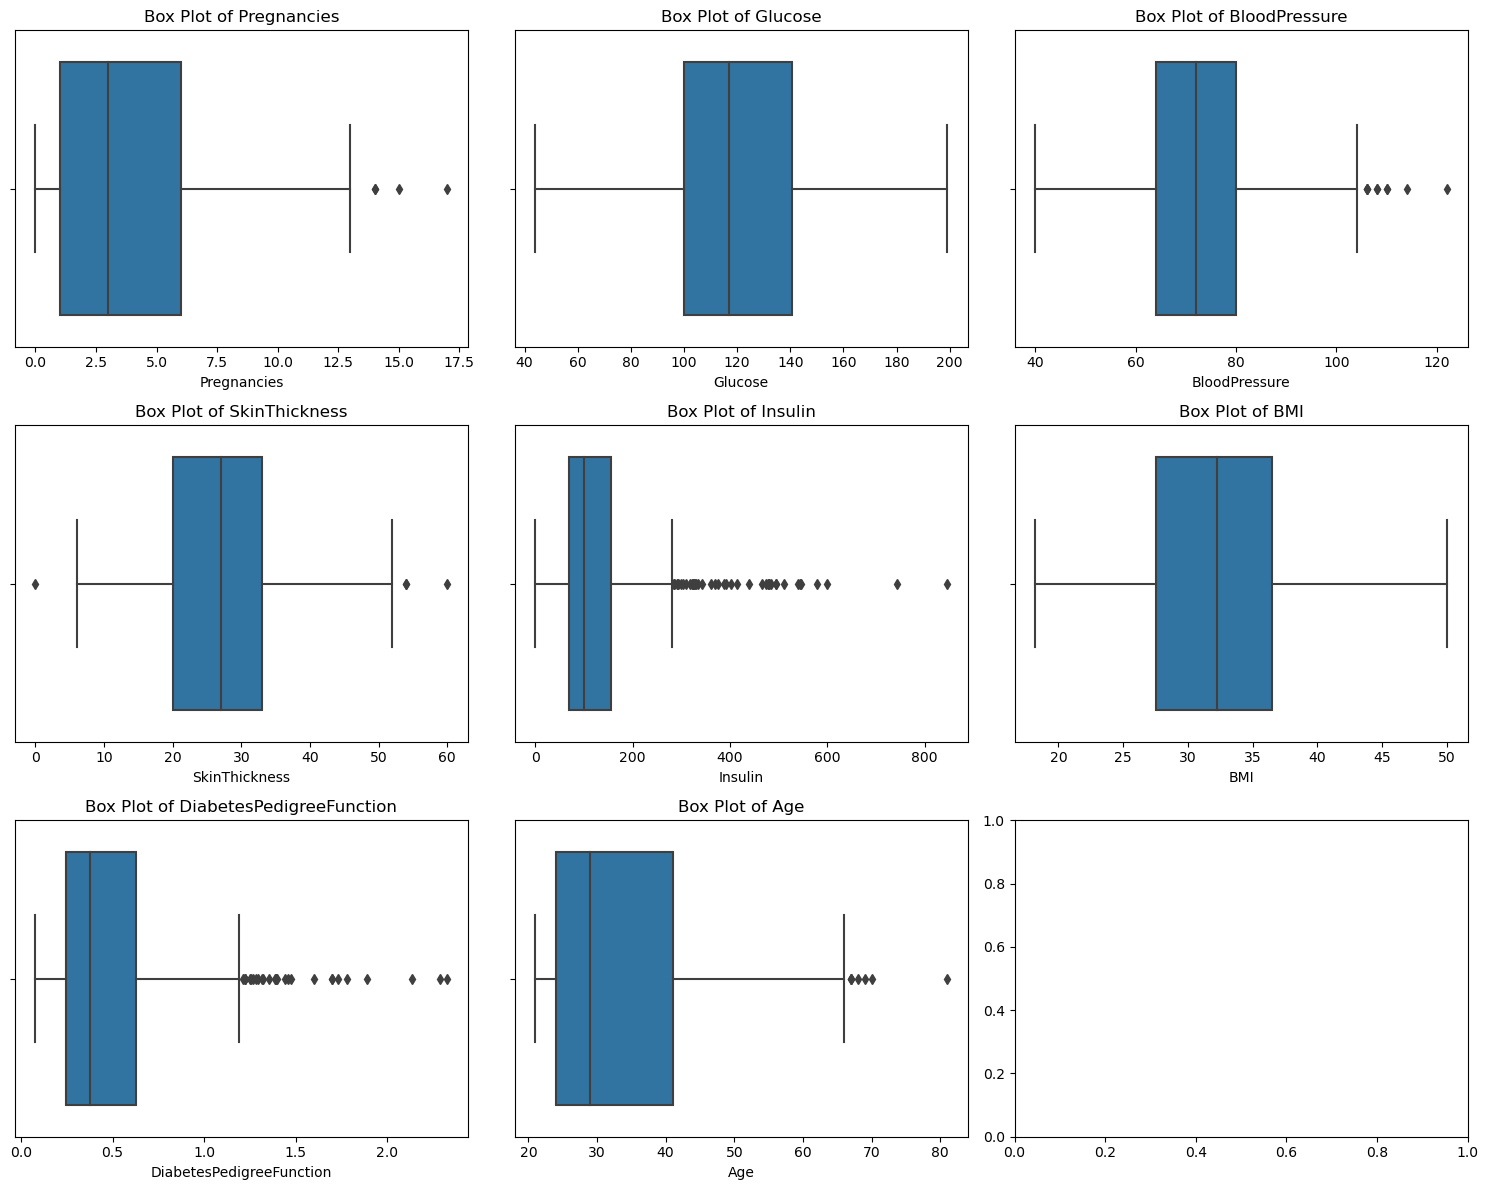

In [21]:
# Same code as from above
n_cols = 3
n_rows = (len(predictor_variables) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))

for i, column in enumerate(predictor_variables):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel(column)

plt.tight_layout()
plt.show()

### NOTE: There are still some outliers present in the data, but we will hopefully be able to mitigate these a little more once we perform some scaling on our data.

#### Let's also plot the distributions of our predictors one more time to see what they look like after the missing values have been dealt with

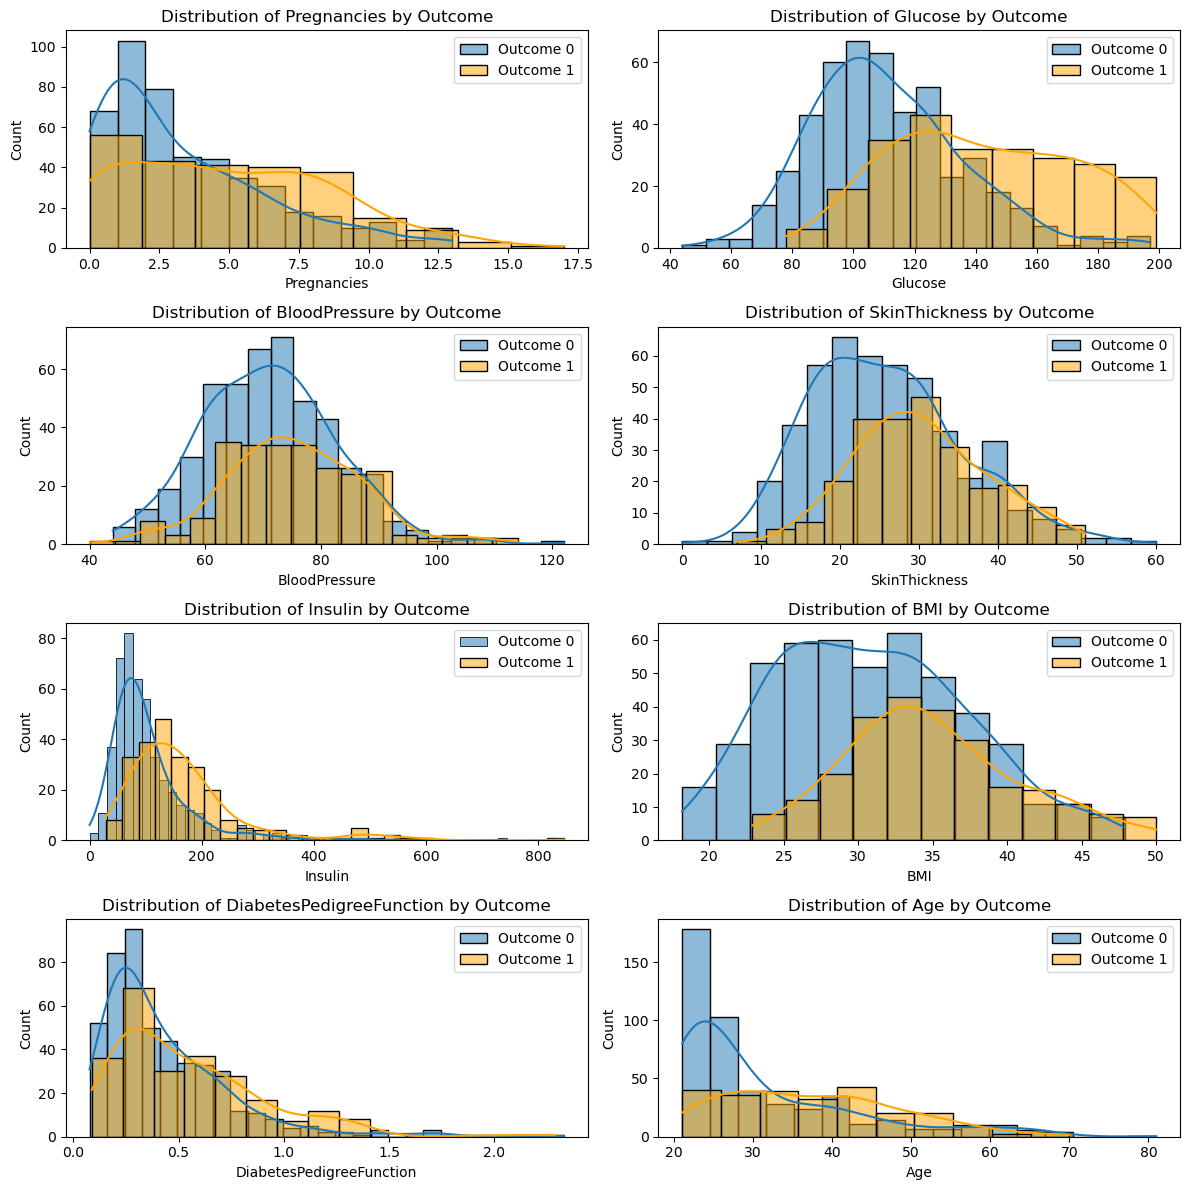

In [22]:
# Working out the number of rows for the distributions if I want 2 columns
n_rows = len(predictor_variables) // 2 + len(predictor_variables) % 2  

# Creating my figure for the distribution grid
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 3 * n_rows))

# Cycling through all predictors and creating an overlapping histogram for both outcomes
for i, column in enumerate(predictor_variables):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Create histograms for 0 and 1 outcomes
    sns.histplot(df[df['Outcome'] == 0][column], kde=True, label='Outcome 0', ax=ax)
    sns.histplot(df[df['Outcome'] == 1][column], kde=True, label='Outcome 1', color='orange', ax=ax)

    ax.set_title(f'Distribution of {column} by Outcome')
    ax.set_xlabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

- These are looking much better than before.  Time for Scaling!

### 3. Scaling and Normalizing

- I decided to use Standard Scaler since it is less sensitive to outliers and lends well to linear models and can help improve the performance of logistic regression models, which is one of the models I plan to try.

In [23]:
# Separating features, X from target, y
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Split the data into training and testing sets - I've used an 80-20 split for this set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Apply StandardScaler to scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 4. Data Imbalance?

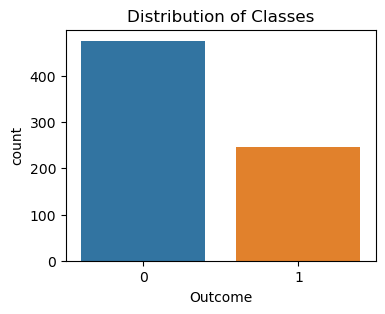

Outcome
0    0.65928
1    0.34072
Name: proportion, dtype: float64


In [25]:
# Checking proportions between outcomes on our dataset
plt.figure(figsize=(4, 3))

sns.countplot(data=df, x='Outcome')
plt.title("Distribution of Classes")
plt.show()

class_proportions = df['Outcome'].value_counts(normalize=True)
print(class_proportions)

In [26]:
# Checking proportions between outcomes on our testing and training sets
# Calculate class distribution in the training set
train_class_distribution = pd.Series(y_train).value_counts(normalize=True)

# Calculate class distribution in the test set
test_class_distribution = pd.Series(y_test).value_counts(normalize=True)

# Compare the class distributions
print("Class distribution in the training set:")
print(train_class_distribution)

Class distribution in the training set:
Outcome
0    0.655113
1    0.344887
Name: proportion, dtype: float64


### Observations
- It Looks like the training and test sets have the same proportionality of outcomes as the original dataset.  In all cases, there are about 66% for those without diabetes and 34% with diabetes.

# Part III : Training ML Model

For this task, you are required to build a machine learning model to predict the outcome variable. This will be a binary classification task, as the target variable is binary. You should select at least two models, one of which should be an ensemble model, and compare their performance.

- Train the models: Train the selected models on the training set.
- Model evaluation: Evaluate the trained models on the testing set using appropriate evaluation metrics, such as accuracy, precision, recall, F1-score, and ROC-AUC.
- Model comparison: Compare the performance of the selected models and choose the best-performing model based on the evaluation metrics. You can also perform additional analysis, such as model tuning and cross-validation, to improve the model's performance.

### Model 1. Logisitic Regression Model with k-fold Cross-Validation and RandomizedSearch
- I'll start with a Logistic Regression model that utilizes k-fold Cross-Validation and Randomized Search
- I chose F1 as the metric here since we want recall (True Postive Rate) to be maximized, but we also want our precision to be maximized as well. Our F1 score is the harmonized mean of the two. 

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [28]:
# Create a Logistic Regression model
lr_model = LogisticRegression()

# Specify hyperparameters and their possible values for tuning
param_dist = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': loguniform(1e-5, 100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  
    'max_iter': [100, 500, 1000]
}

# Create a RandomizedSearchCV object with k-fold cross-validation - using F1 score as our metric
random_search = RandomizedSearchCV(lr_model, param_distributions=param_dist, n_iter=50, cv=10, scoring='f1', n_jobs=-1)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_logistic_reg_model = random_search.best_estimator_
best_hyperparameters = random_search.best_params_

# Evaluate the best model using k-fold cross-validation
cross_val_scores = cross_val_score(best_logistic_reg_model, X_train, y_train, cv=10, scoring='f1')

# Train the best model on the full training set
best_logistic_reg_model.fit(X_train, y_train)

/Users/jlo/anaconda3/envs/LHL_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/jlo/anaconda3/envs/LHL_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jlo/anaconda3/envs/LHL_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/jlo/anaconda3/envs/LHL_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jlo/anaconda3/envs/LHL_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: Fu

LogisticRegression(C=0.0003262606538099859, solver='liblinear')

In [30]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters)

# Print cross-validation results
print("Cross-Validation F1 Scores:")
print(cross_val_scores)
print(f"Mean F1 Score: {np.mean(cross_val_scores):.2f}")

# Make predictions on the test data
logistic_reg_predictions = best_logistic_reg_model.predict(X_test)

# Print our report on performance on the predictions
classification_rep = classification_report(y_test, logistic_reg_predictions)
print("\nClassification Report:")
print(classification_rep)

Best Hyperparameters:
{'C': 0.0003262606538099859, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-Validation F1 Scores:
[0.6        0.69767442 0.68292683 0.66666667 0.63157895 0.61538462
 0.74418605 0.5        0.57142857 0.73684211]
Mean F1 Score: 0.64

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        98
           1       0.56      0.66      0.61        47

    accuracy                           0.72       145
   macro avg       0.69      0.71      0.70       145
weighted avg       0.74      0.72      0.73       145



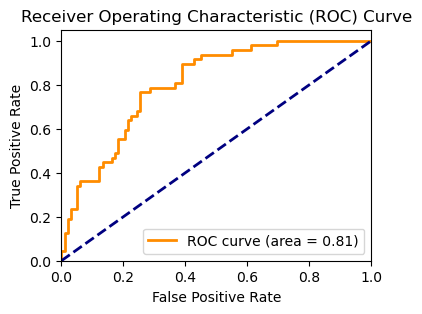

In [31]:
# Calculating the predicted probabilities
logistic_reg_probabilities = best_logistic_reg_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg_probabilities)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Observations
- Logistic Regression Model has an average F1-score of 0.64, which isn't great.
- We'll explore some other models below to see if we can improve this score.

### Model 2. Random Forest vs AdaBoost vs SVM vs LDA vs XGBoost vs Gradient Boosting
- We're going to test a number of ensemble models, along with a couple others to compare their performances.  We will achieve this using a pipeline of models, looping through all of them, applying a grid search, and determining which is best.

In [32]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
# Create pipelines for different models
pipelines = {
    'Random Forest': Pipeline([('model', RandomForestClassifier())]),
    'AdaBoost': Pipeline([('model', AdaBoostClassifier())]),
    'Support Vector Machine': Pipeline([('model', SVC())]),
    'Linear Discriminant Analysis': Pipeline([('model', LinearDiscriminantAnalysis())]),
    'XGBoost': Pipeline([('model', XGBClassifier())]),
    'Gradient Boosting': Pipeline([('model', GradientBoostingClassifier())])
}

In [34]:
# Create a dictionary of parameters for each of the models.
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 5, 10, 20],
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__base_estimator': [None, RandomForestClassifier(max_depth=2, random_state=42), DecisionTreeClassifier(max_depth=2, random_state=42)],
    },
    'Support Vector Machine': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    'Linear Discriminant Analysis': {},
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__max_depth': [3, 5, 7],
    }
}

In [35]:
results = []

# Looping through each of the models on the pipline, along with their parameters, using a grid search to determine the best tuning for each of
# these models
for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)

    # Calulating f1 score of the model and generating the classification report to extract the other scores
    f1 = f1_score(y_test, predictions)
    classification_rep = classification_report(y_test, predictions, output_dict=True)

    # Appending the results of each model to the results list of dictionaries
    results.append({
        'Model': model_name,
        'Best Model': best_model,
        'F1 Score': f1,
        'Precision': classification_rep['1']['precision'],
        'Recall': classification_rep['1']['recall'],
        'Accuracy': classification_rep['accuracy'],
    })
    
# Turning our results into a dataframe for ease of viewability
results_df = pd.DataFrame(results)

In [36]:
results_df

,Model,Best Model,F1 Score,Precision,Recall,Accuracy
0,Random Forest,"((DecisionTreeClassifier(max_depth=5, max_feat...",0.659341,0.681818,0.638298,0.786207
1,AdaBoost,"((DecisionTreeClassifier(max_depth=1, random_s...",0.666667,0.653061,0.680851,0.779310
2,Support Vector Machine,"(SVC(C=1, kernel='linear'))",0.622222,0.651163,0.595745,0.765517
3,Linear Discriminant Analysis,(LinearDiscriminantAnalysis()),0.606742,0.642857,0.574468,0.758621
4,XGBoost,"(XGBClassifier(base_score=None, booster=None, ...",0.623656,0.630435,0.617021,0.758621
5,Gradient Boosting,(([DecisionTreeRegressor(criterion='friedman_m...,0.608696,0.622222,0.595745,0.751724


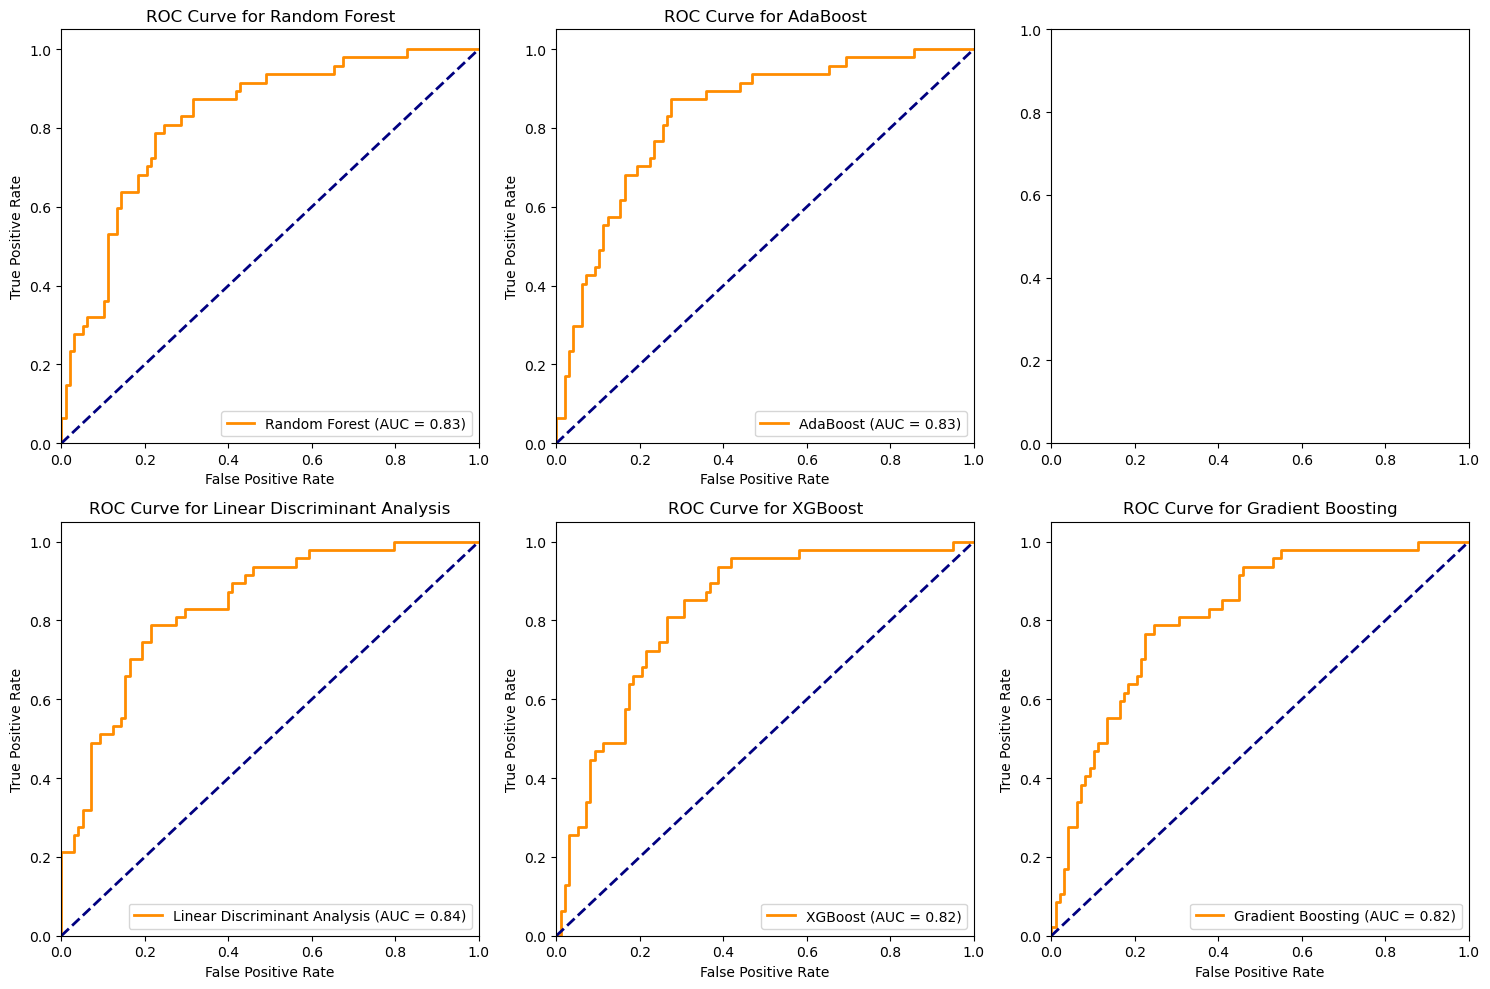

In [37]:
# Create subplots for ROC curves
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, row in results_df.iterrows():
    model_name = row['Model']
    best_model = row['Best Model']
    
    #Checking to see whether the model has the attribute "predict_proba", which is necessary for the ROC curve
    if hasattr(best_model, 'predict_proba'):
        y_scores = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        ax = axes[i]
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for {model_name}')
        ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### Observations
- Overall these models perform about the same, but we can see that AdaBoost and Random Forest methods have an edge in Precision and Recall, while AdaBoost, Random Forest, and SVC have an edge in Accuracy.  As far as ROC scores, all models are pretty close again, with LDA coming in with a score of 0.84.
- AdaBoost definitely comes out on top amongst the models when we consider that recall and precision is what we'd like to maximize in this case.

### Model 3: Stacking - Voting Classifier

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier  #meta model

In [39]:
# Creating a voting classifier using scikit-learn's VotingClassifier

classifiers = {
    "Decision Tree"         : DecisionTreeClassifier(max_depth=5),
    "AdaBoost"              : AdaBoostClassifier(),
    "LDA"                   : LinearDiscriminantAnalysis(),    
    "KNN"                   : KNeighborsClassifier(),
    "Naive Bayes"           : GaussianNB(),
    "Logistic Regression"   : LogisticRegression(),
}

# voting="soft" predicts the class label based on the argmax of the sums of the predicted probabilities
ensemble = VotingClassifier(list(classifiers.items()), voting="soft")

# note: sklearn doesn't seem to support passing pre-trained classifiers into VotingClassifier
ensemble.fit(X_train, np.ravel(y_train))

print('Ensemble performance: \n')
print("Training error:   %.2f" % (1-ensemble.score(X_train, y_train)))
print("Testing error: %.2f" % (1-ensemble.score(X_test, y_test)))

Ensemble performance: 

Training error:   0.19
Testing error: 0.21


In [40]:
## What's the performance of individual classifiers in the ensemble?
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    tr_err = (1 - estimator.score(X_train, y_train))
    te_err = (1 - estimator.score(X_test, y_test))
    print('%s: Train_error: %0.3f; Validation error: %0.3f'%(name, tr_err, te_err))

Decision Tree: Train_error: 0.153; Validation error: 0.290
AdaBoost: Train_error: 0.165; Validation error: 0.221
LDA: Train_error: 0.225; Validation error: 0.241
KNN: Train_error: 0.194; Validation error: 0.255
Naive Bayes: Train_error: 0.236; Validation error: 0.297
Logistic Regression: Train_error: 0.222; Validation error: 0.241


F1 Score: 0.651685393258427
Accuracy: 0.7862068965517242
Precision: 0.6904761904761905
Recall: 0.6170212765957447
ROC AUC: 0.8256621797655233


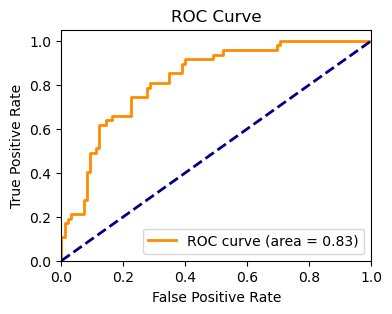

In [41]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

predictions = ensemble.predict(X_test)
y_scores = ensemble.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, y_scores)

print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Part IV : Conclusion

From the machine learning models developed and the exploratory data analysis (EDA) conducted, generate four bullet points as your findings.

- There were not many strong correlations between our predictors and our target - glucose was the best of them all.  Due to this, our generated models were not performing the way we would like them to.  In the end, we wanted to see a high recall score from our models since we are dealing with daignosis and thus, want a high True Positive Rate.  
- I expected the ensemble models to out perform the logisitic regression, but a couple only did marginally better.  The Logistic Regression model had an F1 score of 0.64, while the next best performer was AdaBoost with an F1 score of almost 0.67.  Both had similar ROC curves, with AdaBoost coming out on top with an AUC of 0.83.
- Using stacking was a good thought as well, but I was again surprised to see that this method also didn't yeild much better results than the Logistic Regression. With stacking, we achieved an F1 score of 0.65 and an AUC of 0.83.
- Overall, Boosting seemed to be the most effective method for achieving higher F1 scores - with AdaBoosting being our top performer.  If I had more time, I'd focus in on AdaBoost more and hypertune it to hopefully get better results.  I'd also try and use a different scaling and normalization method - Something that handles outliers a little bit better.
